<a href="https://colab.research.google.com/github/Vishal-74/MachineLearningProjects/blob/main/Transfer_Learning_on_CatsVsDogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[TensorFlow Hub](http://tensorflow.org/hub)

[TensorFlow Module Hub](https://tfhub.dev/).



In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers

By setting the logging level to ERROR, the intention is likely to suppress less critical log messages (e.g., DEBUG, INFO, WARNING, ERROR) and only display or handle error-level messages or more critical issues during the execution of the code

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

### MobileNet for prediction

[tf2 compatible image classifier URL from tfhub.dev](https://tfhub.dev/s?q=tf2&module-type=image-classification)

In [4]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

Python Imaging Library - PIL

1. download an image file named 'image.jpg' using `tf.keras.utils.get_file()`
2. opening the image and resizing it using `Image.open().resize()`

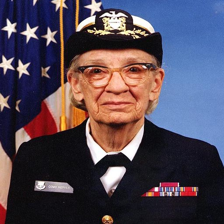

In [5]:
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper

 Normalizing pixel values to a range between 0 and 1

In [6]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

we add a batch dimension, and pass the image to the model for prediction.

--> The np.newaxis is used to add a new dimension to the array, specifically at the beginning (axis 0).

--> The ... (ellipsis) is a shortcut in NumPy to indicate all the other dimensions in the array remain unchanged.

In [7]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

1/1 [==============================] - 3s 3s/step


(1, 1001)

we get 1 result back with the probability distribution across 1,001 classes
(ImageNet has 1001 classes)

array([[ 0.1996763 ,  1.0678949 , -0.09609801, **...** ,  0.1060295 ,
        -0.56031984, -0.07089178]], dtype=float32)

`result[0]` represents the model's prediction for the single image in the batch

axis=0 refers to operations along the rows (vertical axis).

axis=1 refers to operations along the columns (horizontal axis).

axis=-1, refers to the last axis regardless of the specific number of axes present in the array



In [8]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

The .title() method in Python is used to capitalize the first letter of each word in a string (i.e, in predicted_class_name.title() this will convert dog --> Dog)

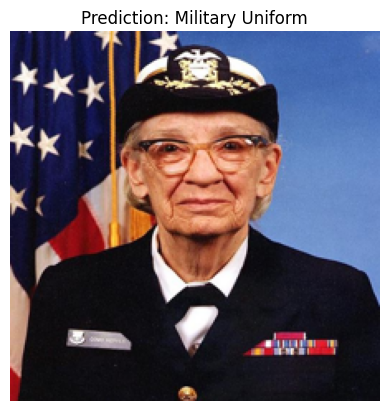

In [9]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

### TensorflowHub model for dogs vs cats

### Dataset

Train_examples with num_examples and num_classes (categories)

and validation_examples






retrieve the total number of examples in the 'train' split of the dataset, specifically from the information (info)

In [10]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs',
    with_info=True,
    as_supervised=True,
    split=['train[:80%]', 'train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

`example_image[0]` accesses the image data (assuming the dataset is structured as (image, label) tuples) and .shape retrieves the shape of the image data.

In [11]:
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (262, 350, 3)
Image 2 shape: (409, 336, 3)
Image 3 shape: (493, 500, 3)


`def format_image` takes "image" as input and convert into specific resolutin of "(IMGAGE_RES,IMAGE_RES)" then /255.0 is applied and we return image with original label

`train_batches` takes all the dataset and shuffles with buffer = 1/4th of total no. of training example shuffles the subset of dataset within a buffer window then `.map()` the "format_image" function (defined earlier) to each example in the dataset and `.batch(BATCH_SIZE)` creates batches of examples for training,

`.prefetch(1)` prefetches the dataset to optimize data loading. The argument 1 specifies to prefetch a single batch. Prefetching overlaps the preprocessing and model execution of one batch with the training of another batch, helping to speed up training by reducing data loading times.







In [12]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

`image_batch, label_batch = next(iter(train_batches.take(1)))` extract a single batch of images and their corresponding labels from the train_batches dataset

`image_batch.numpy()` converts the TensorFlow tensor image_batch to a NumPy array representation

In [13]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

1/1 [==============================] - 1s 1s/step


array(['bath towel', 'tabby', 'Siamese cat',
       'American Staffordshire terrier', 'lynx', 'Egyptian cat',
       'Egyptian cat', 'boxer', 'French bulldog', 'Saint Bernard',
       'American Staffordshire terrier', 'kelpie', 'Egyptian cat',
       'redbone', 'lynx', 'tiger cat', 'Egyptian cat', 'tabby',
       'French bulldog', 'Norwegian elkhound', 'Eskimo dog',
       'Bernese mountain dog', 'Chihuahua', 'Egyptian cat',
       'Newfoundland', 'Siamese cat', 'Labrador retriever', 'tiger cat',
       'Norwich terrier', 'giant schnauzer', 'Shetland sheepdog',
       'Egyptian cat'], dtype='<U30')

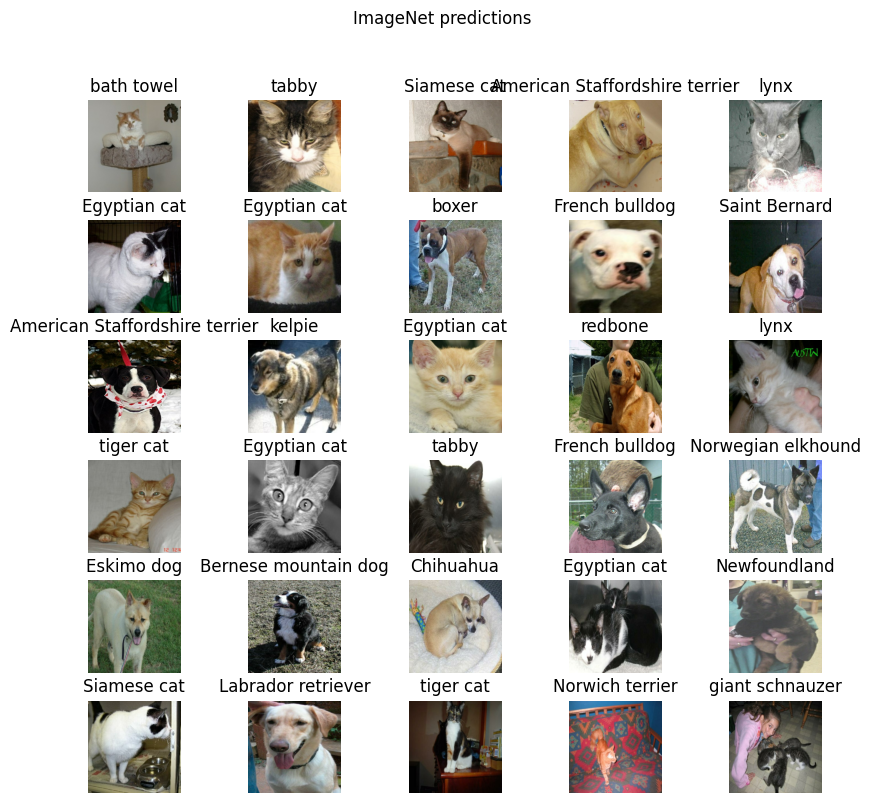

In [14]:
plt.figure(figsize=(10,9))
for n in range(30):                         #30 plots
  plt.subplot(6,5,n+1)                      #6x5grid & postition is n+1 = [1,2,3]
  plt.subplots_adjust(hspace = 0.3)         #adjusting vertical spacing b/w subplots
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

### Transfer learning

we're calling the partial model from TensorFlow Hub (without the final classification layer) a `feature_extractor`.

In [15]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

`feature_batch` will contain the extracted features from the batch of images. The extracted features are representations learned by the MobileNet V2 model for each image in the batch, capturing high-level information or patterns that the model has identified as important for classification or other tasks.


*   32 corresponds to the batch size, indicating that the feature extraction was performed on a batch of 32 images.
*   1280 represents the dimensionality or length of each feature vector.




In [16]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


Freeze the variables in the feature extractor layer, so that the training only modifies the final classifier layer.

In [17]:
feature_extractor.trainable = False

In [18]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


`from_logits=True` indicates that the model's output is not normalized (logits) and needs to be interpreted as raw predictions before normalization (softmax).


*   Logits: Logits refer to the raw, unnormalized predictions generated by a neural network before they are transformed into probabilities using a softmax function. Logits are often used as inputs to a softmax function to obtain normalized probability distributions over the predicted classes.
*   Softmax function: The softmax function is commonly applied to logits to convert them into probabilities. It normalizes the logits into a probability distribution, ensuring that the predicted probabilities sum up to 1 across all classes, making them interpretable as class probabilities.



In [19]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

`steps_per_epoch` determines the number of steps (batches) to be processed in each epoch during training. Each step (or batch) involves one optimization step using a batch of training data.

`steps_per_epoch=len(train_batches)` It means that each epoch will iterate through the entire training dataset exactly once before moving to the next epoch.

default --> total examples/batch size = 1000/32

In [20]:
import gc
gc.collect()
# !cat /proc/meminfo for checking memory usage
# tf.device('/GPU:0') for gpu memory management, make sure that your tensors and models are moved to and processed on the GPU

161

In [21]:
EPOCHS = 5
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_batches),
                    validation_steps=len(validation_batches),
                    validation_data=validation_batches)

Epoch 1/5
582/582 [==============================] - 46s 61ms/step - loss: 0.0567 - accuracy: 0.9796 - val_loss: 0.0351 - val_accuracy: 0.9895
Epoch 2/5
582/582 [==============================] - 45s 66ms/step - loss: 0.0308 - accuracy: 0.9891 - val_loss: 0.0348 - val_accuracy: 0.9873
Epoch 3/5
582/582 [==============================] - 47s 70ms/step - loss: 0.0249 - accuracy: 0.9915 - val_loss: 0.0320 - val_accuracy: 0.9886
Epoch 4/5
582/582 [==============================] - 40s 61ms/step - loss: 0.0213 - accuracy: 0.9924 - val_loss: 0.0445 - val_accuracy: 0.9867
Epoch 5/5
582/582 [==============================] - 41s 62ms/step - loss: 0.0185 - accuracy: 0.9937 - val_loss: 0.0350 - val_accuracy: 0.9903


The history object has a history attribute. This history attribute is a dictionary-like structure that holds the training metrics history.

When we access history.history, it returns a dictionary where the keys are strings representing the names of the metrics (e.g., 'accuracy', 'loss', 'val_accuracy', 'val_loss') and the values are lists containing the corresponding metric values recorded at the end of each epoch during the training process.
```

print(history.history)

 > {
      'accuracy': [0.5, 0.7, 0.8, ...],
      'loss': [1.2, 0.9, 0.6, ...],
      'val_accuracy': [0.6, 0.75, 0.82, ...],
      'val_loss': [1.0, 0.8, 0.5, ...],
      # Additional metrics if specified during training...
   }

```




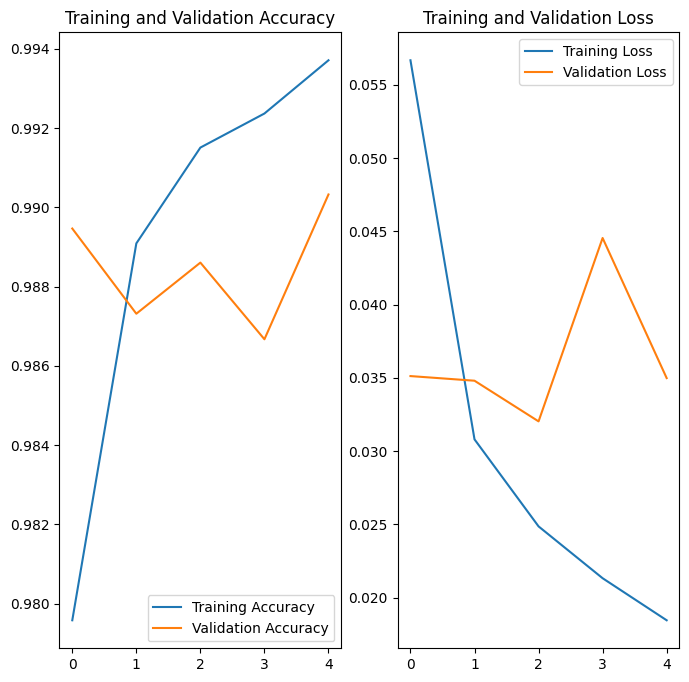

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))                                    #widthxheight = 8x8
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Validation performance is bettter from start bcz we're reusing a large part of MobileNet which is already trained on Dogs and Cats images. While doing training, the network is still performing image augmentation on the training images, but not on the validation dataset. This means the training images may be harder to classify compared to the normal images in the validation dataset.

obtainaing an array of class names from a TensorFlow Datasets (tfds) info object

In [23]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [24]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

1/1 [==============================] - 0s 483ms/step


array(['cat', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog',
       'dog', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat',
       'dog', 'dog', 'dog', 'dog', 'dog', 'cat', 'dog', 'cat', 'dog',
       'cat', 'cat', 'cat', 'dog', 'cat'], dtype='<U3')

In [25]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [0 0 0 1 0 0 0 1 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 0 1 0 1 0 0 0 1 0]
Predicted labels:  [0 0 0 1 0 0 0 1 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 0 1 0 1 0 0 0 1 0]


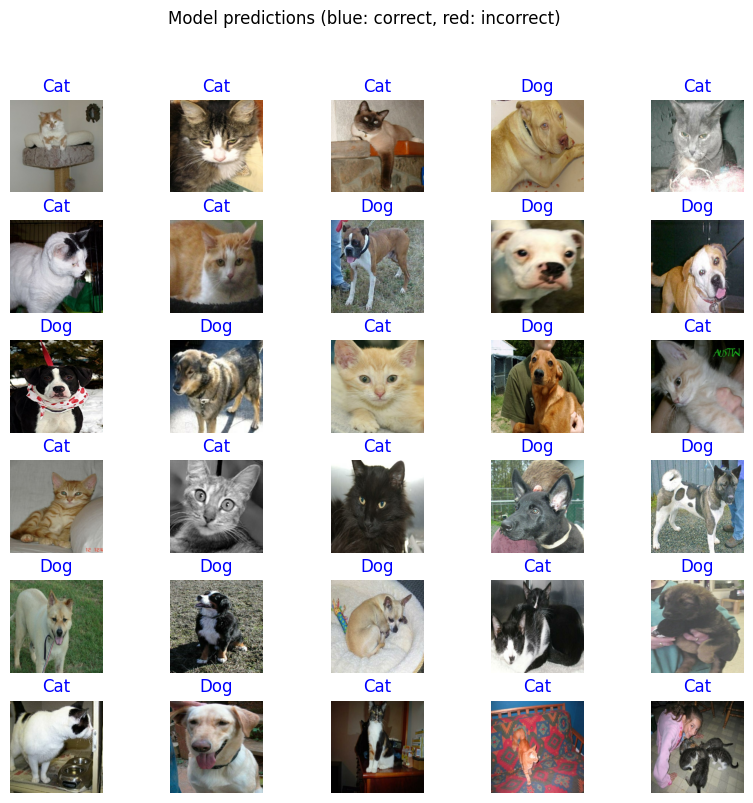

In [26]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")